In [1]:
import matplotlib.pyplot as plt
import numpy as np
import copy
import h5py
import os
import seaborn as sns
from pyscf.scf.uhf import det_ovlp

In [2]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def HF_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; F 0. 0. 0.8",
        basis=f"ccecpccpvdz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 6,2)
    # mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [3]:
# Wavefunction generation
from pyscf import lib, gto, scf
from pyscf import gto, mp, mcscf
def H2_casci(scf_checkfile, ci_checkfile):
    mol = gto.M(
        atom="H 0. 0. 0.0; H 0. 0. 1.4",
        basis=f"ccecpccpvdz",
        unit="bohr",
        charge=0,
        spin=0,
        verbose=1,
    )
    mf = scf.UHF(mol).run()
    mf.chkfile = scf_checkfile
    mf.kernel()
    mc = mcscf.CASCI(mf, 6,2)
    # mc.fcisolver.nroots = 4
    mc.kernel()
    print(mc.__dict__.keys())
    with h5py.File(ci_checkfile, "a") as f:
        f.create_group("ci")
        f["ci/ncas"] = mc.ncas
        f["ci/nelecas"] = list(mc.nelecas)
        f["ci/ci"] = mc.ci
        f["ci/mo_coeff"] = mc.mo_coeff    
    return mol, mf, mc

In [35]:
scf_checkfile = 'rohf.chk'
ci_checkfile = 'casci.chk'
for fname in [scf_checkfile, ci_checkfile]:
    if os.path.isfile(fname):
        os.remove(fname)
# mol, mf, mc = H2_casci(scf_checkfile, ci_checkfile)
mol, mf, mcc = HF_casci(scf_checkfile, ci_checkfile)

dict_keys(['mol', '_scf', 'verbose', 'stdout', 'max_memory', 'ncas', 'nelecas', '_ncore', 'fcisolver', 'frozen', 'extrasym', 'e_tot', 'e_cas', 'ci', 'mo_coeff', 'mo_energy', 'mo_occ', 'converged'])


# Using PYSCF method using output from PYQMC

In [36]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
# wf.parameters['det_coeff'] = np.ones(len(wf.parameters['det_coeff']))
signb, phib = wf1.recompute(configs)
num_ao = wf1._aovals.shape[-1]

In [37]:
det_dim = wf1._dets[0][1].shape[-1]

In [38]:
n = np.array(wf1._det_occup)
occ_arr_shape = (n.shape[0], n.shape[1], num_ao)
occ_arr = np.zeros(occ_arr_shape)
for i in range(n.shape[0]):
    for j in range(n.shape[1]):
        occ_arr[i,j][n[i,j]]=1

In [39]:
mcc.mo_coeff = np.array([mcc.mo_coeff, mcc.mo_coeff]) 

In [41]:
ovlp_mat = np.zeros((det_dim, det_dim))
for i1 in range(det_dim):
    for i2 in range(det_dim):
        det1_occ = np.array([occ_arr[0, i1], occ_arr[1, i1]])
        det2_occ = np.array([occ_arr[0, i2], occ_arr[1, i2]])
        
        ovlp, _ = det_ovlp(mcc.mo_coeff,mcc.mo_coeff, det1_occ, det2_occ, mf.get_ovlp())
        ovlp_mat[i1, i2] = ovlp

<Axes: >

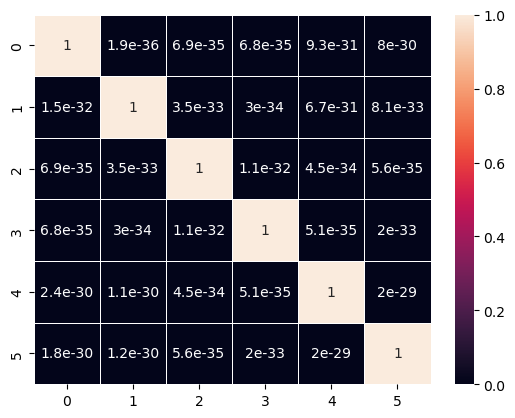

In [42]:
sns.heatmap(ovlp_mat, annot=True, linewidths=.5)

# Using statistical PYQMC method

In [72]:
import bosonslater 
import pyscftools, mc
wf1 = bosonslater.BosonWF(mol, mf, mc=mcc)

nconfig = 1000
mol, mf = pyscftools.recover_pyscf(scf_checkfile)
configs = mc.initial_guess(mol, nconfig)
# wf.parameters['det_coeff'] = np.ones(len(wf.parameters['det_coeff']))
signb, phib = wf1.recompute(configs)
sign, logval = wf1.value()
val = np.exp(logval)
rho = val **2 

In [46]:
updets = wf1._dets[0][:, :, wf1._det_map[0]]
dndets = wf1._dets[1][:, :, wf1._det_map[1]]

# nup = np.einsum('ni, ni, nj, nj->nij', updets[0], np.exp(updets[1]), updets[0], np.exp(updets[1]))
# ndn = np.einsum('ni, ni, nj, nj->nij', dndets[0], np.exp(dndets[1]), dndets[0], np.exp(dndets[1]))

In [54]:
updets.shape

(2, 1000, 36)

In [55]:
dndets.shape

(2, 1000, 36)

In [104]:
norm_rho = rho/np.sum(rho)

In [96]:
nup = np.einsum('ni, ni, ni, ni->ni', updets[0], np.exp(updets[1]), updets[0], np.exp(updets[1]))
ndn = np.einsum('ni, ni, ni, ni->ni', dndets[0], np.exp(dndets[1]), dndets[0], np.exp(dndets[1]))
psi_i = np.einsum('ni, ni, ni, ni->ni', updets[0], np.exp(updets[1]), dndets[0], np.exp(dndets[1]))
psi_ij = np.sqrt(np.einsum('ni, ni->ni', psi_i, psi_i))
psi_ij = psi_ij.reshape(1000, 6,6)

In [101]:
nup.shape

(1000, 36)

In [105]:
ovlp_ij  = nup * ndn 
w_ovlp_ij = np.einsum('ni, ni, n ->ni', nup, ndn, norm_rho)

In [ ]:
m_ovlp_ij = ovlp_ij.reshape(1000, 6,6)
m_w_ovlp_ij = w_ovlp_ij.reshape(1000, 6,6)

<Axes: >

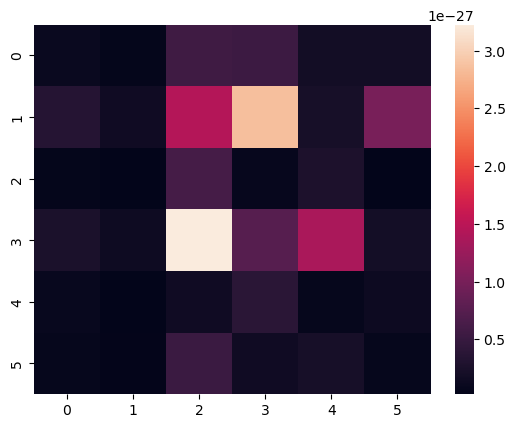

In [106]:
mat = np.average(m_w_ovlp_ij, axis=0) 
sns.heatmap(mat)

<Axes: >

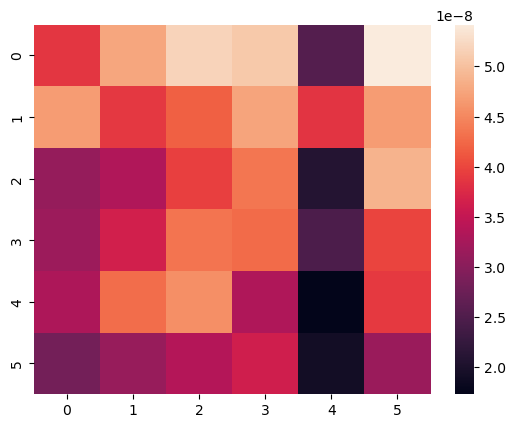

In [93]:
mat = np.average(m_ovlp_ij/psi_ij, axis=0) 
sns.heatmap(mat)

<Axes: >

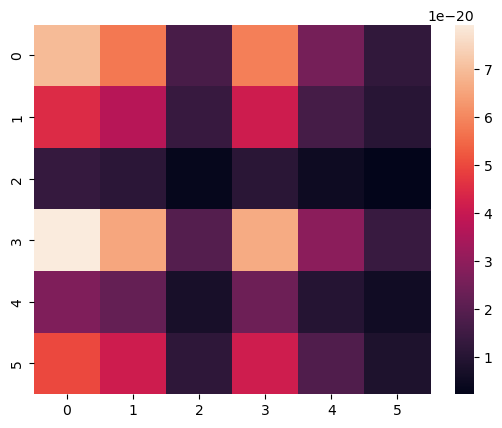

In [94]:
mat = np.average(m_w_ovlp_ij/psi_ij, axis=0) 
sns.heatmap(mat)

In [46]:
# mc.verbose = 4
# _ = mc.analyze()

In [9]:
# tol = 10**-2
# mc.fcisolver.large_ci(mc.ci[0], mc.ncas, mc.nelecas, tol, return_strs=False)

In [10]:
# tol = 10**-2
# mc.fcisolver.large_ci(mc.ci[1], mc.ncas, mc.nelecas, tol, return_strs=False)

In [11]:
# # np.max(np.abs(mc.ci), axis=0)


# addra, addrb = numpy.where(abs(mc.ci) > tol)
# addra, addrb

In [12]:
from recipes import initialize_qmc_objects
wf0, _, _ = initialize_qmc_objects(scf_checkfile, nconfig=1000, ci_checkfile=ci_checkfile, target_root=0, jastrow_kws=None)

In [29]:
wf1, _, _ = initialize_qmc_objects(scf_checkfile, nconfig=1000, ci_checkfile=ci_checkfile, target_root=1)


> /Users/ksu/Documents/GitHub/pyqmc/pyqmc/recipes.py(214)initialize_qmc_objects()
    212     import pdb
    213     pdb.set_trace()
--> 214     wf, to_opt = wftools.generate_wf(
    215         mol, mf, mc=mc, jastrow_kws=jastrow_kws, slater_kws=slater_kws
    216     )



ipdb>  c


In [30]:
wf0.wf_factors[0]._det_occup

[[[0, 1, 2, 3, 4],
  [0, 1, 2, 3, 5],
  [0, 1, 2, 3, 6],
  [0, 1, 2, 3, 7],
  [0, 1, 2, 3, 8],
  [0, 1, 2, 3, 9]],
 [[0, 1, 2, 3, 4],
  [0, 1, 2, 3, 5],
  [0, 1, 2, 3, 6],
  [0, 1, 2, 3, 7],
  [0, 1, 2, 3, 8],
  [0, 1, 2, 3, 9]]]

In [31]:
wf1.wf_factors[0]._det_occup

[[[0, 1, 2, 3, 4],
  [0, 1, 2, 3, 5],
  [0, 1, 2, 3, 6],
  [0, 1, 2, 3, 7],
  [0, 1, 2, 3, 8],
  [0, 1, 2, 3, 9]],
 [[0, 1, 2, 3, 4],
  [0, 1, 2, 3, 5],
  [0, 1, 2, 3, 6],
  [0, 1, 2, 3, 7],
  [0, 1, 2, 3, 8],
  [0, 1, 2, 3, 9]]]

In [35]:
wf0.wf_factors[0]._det_map

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5],
       [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
        4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

In [37]:
wf1.wf_factors[0]._det_map

array([[0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3,
        3, 3, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5],
       [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3,
        4, 5, 0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]])

In [447]:
# i = 0
# j = 1
# ovlp = numpy.dot(mc.ci[i].ravel().conj(),mc.ci[j].ravel())
# ovlp

In [448]:
# ci0 = copy.deepcopy(mc.ci[0])
# ci1 = copy.deepcopy(mc.ci[0])
# ci0[1]*=0
# ci0[2]*=0
# ci0[3]*=0
# ci0[4]*=0
# ci0[5]*=0

# ci1[1]*=0
# ci1[2]*=0
# ci1[3]*=0
# ci1[4]*=0
# ci1[5]*=0
# ovlp = numpy.dot(ci0.ravel().conj(),ci1.ravel())
# ovlp

In [335]:
myhf1 = gto.M(atom='H 0 0 0; F 0 0 1.1', basis='6-31g', verbose=0).apply(scf.RHF).run()
norb = 4
nelec = 4
mc1 = mcscf.CASCI(myhf1, norb, nelec).run()
# mo0 = mc1.mo_coeff
# ci0 = mc1.ci
# ci1 = copy.deepcopy(mc1.ci)
# ci0[0]*=0
# ci0[2]*=0
# ci0[3]*=0
# ci0[4]*=0
# ci0[5]*=0

# ci1[0]*=0
# ci1[2]*=0
# ci1[3]*=0
# ci1[4]*=0
# ci1[5]*=0

# print('CASCI energy of mol1', mc1.e_tot)

# i = 5
# j = i
# s = numpy.einsum('pi,pq,qj->ij', mo0[:,i:i+norb], myhf1.get_ovlp(), mo0[:,j:j+norb])
# # here s = 1
# # s12 = pyscf.gto.intor_cross('int1e_ovlp', myhf1.mol, myhf1.mol)
# # s12 is equal to myhf1.get_ovlp()

# # fci.addons.overlap(ci0,ci1, norb, nelec, s)
# # When s = 1, above is equal to ci0.ravel().conj()*ci1.ravel()
# ovlp = numpy.dot(ci0.ravel().conj(),ci1.ravel())
# ovlp

In [336]:
mc1.dump_flags(verbose=5)


******** CASCI flags ********
CAS (2e+2e, 4o), ncore = 3, nvir = 4
natorb = False
canonicalization = True
sorting_mo_energy = False
max_memory 4000 (MB)
******** <class 'pyscf.fci.direct_spin1.FCISolver'> ********
max. cycles = 200
conv_tol = 1e-08
davidson only = False
linear dependence = 1e-12
level shift = 0.001
max iter space = 12
max_memory 4000 MB
nroots = 1
pspace_size = 400
spin = None


In [337]:
mo_coeff=mc1.mo_coeff
ncore = mc1.ncore
ncas = mc1.ncas
nocc = ncore + ncas
nelecas = mc1.nelecas
nmo = mo_coeff.shape[1]

In [338]:
print(ncore, ncas, nocc, nelecas, nmo)

3 4 7 (2, 2) 11


In [306]:
from pyscf.scf.uhf import det_ovlp

In [317]:
mc1.ci

FCIvector([[ 9.99783973e-01, -8.32667268e-17,  1.13059448e-18,
            -1.40306585e-17,  4.63983384e-18,  3.56889192e-19],
           [ 2.20927839e-18, -1.24280732e-02, -1.56013432e-19,
            -5.17695209e-03,  6.87437708e-19, -9.56092958e-20],
           [-2.38629365e-17, -5.13587344e-19, -1.24280732e-02,
             3.48524248e-19, -5.17695209e-03,  2.85868189e-19],
           [-6.04319748e-18, -5.17695209e-03,  3.74941747e-19,
            -2.81861070e-03, -3.16171529e-20, -3.75837210e-20],
           [ 1.98686150e-18,  4.92676974e-19, -5.17695209e-03,
             1.49450867e-19, -2.81861070e-03,  2.10775094e-19],
           [ 3.49356679e-19, -1.52128135e-19,  5.84462372e-20,
            -8.71383179e-20,  3.61515266e-20,  2.03837436e-05]])

In [322]:
mo_coeff=mc1.mo_coeff.shape

In [308]:
det_ovlp(mc1.mo_coeff[0],mc1.mo_coeff[1], mc1.mo_occ[0], mc1.mo_occ[1], myhf1.get_ovlp())

TypeError: 'NoneType' object is not subscriptable

In [318]:
dir(mc1)

['COSX',
 'DDCOSMO',
 'Gradients',
 'QMMM',
 '__call__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_eig',
 '_finalize',
 '_keys',
 '_ncore',
 '_scf',
 'analyze',
 'ao2mo',
 'apply',
 'as_scanner',
 'canonicalization',
 'canonicalize',
 'canonicalize_',
 'cas_natorb',
 'cas_natorb_',
 'casci',
 'check_sanity',
 'ci',
 'converged',
 'copy',
 'ddCOSMO',
 'density_fit',
 'dump_flags',
 'e_cas',
 'e_tot',
 'energy_nuc',
 'extrasym',
 'fcisolver',
 'fix_spin',
 'fix_spin_',
 'frozen',
 'get_fock',
 'get_h1cas',
 'get_h1eff',
 'get_h2cas',
 'get_h2eff',
 'get_hcore',
 'get_jk',
 'get_veff',
 'h1e_for_cas',
 'kernel',
 'make_rdm1',
 'make_rdm1s',
 'max_

In [312]:
myhf1 = pyscf.M(atom='H 0 0 0; F 0 0 1.1', basis='6-31g', verbose=0).RHF().run()
e1, ci1 = pyscf.fci.FCI(myhf1).kernel()
print('FCI energy of mol1', e1)

FCI energy of mol1 -100.1021146566482


In [313]:
ci1.mo_occ

AttributeError: 'FCIvector' object has no attribute 'mo_occ'

In [296]:
myhf1 = pyscf.M(atom='H 0 0 0; F 0 0 1.1', basis='6-31g', verbose=0).RHF().run()
e1, ci1 = pyscf.fci.FCI(myhf1).kernel()
print('FCI energy of mol1', e1)

myhf2 = pyscf.M(atom='H 0 0 0; F 0 0 1.2', basis='6-31g', verbose=0).RHF().run()
e2, ci2 = pyscf.fci.FCI(myhf2).kernel()
print('FCI energy of mol2', e2)

FCI energy of mol1 -100.1021146566482
FCI energy of mol2 -100.08393757040976


In [297]:
s12 = pyscf.gto.intor_cross('int1e_ovlp', myhf1.mol, myhf2.mol)
s12 = reduce(numpy.dot, (myhf1.mo_coeff.T, s12, myhf2.mo_coeff))

In [299]:
norb = myhf2.mo_energy.size
nelec = myhf2.mol.nelectron
print('<FCI-mol1|FCI-mol2> = ', pyscf.fci.addons.overlap(ci1, ci2, norb, nelec, s12))

<FCI-mol1|FCI-mol2> =  0.39963236744209335


In [293]:
ci1.shape

(6, 6)

In [286]:
ci2

FCIvector([[ 9.77930458e-01, -8.66822956e-18, -4.80516072e-17, ...,
            -5.46783436e-20,  4.39942545e-08, -2.06192228e-07],
           [-8.66822956e-18, -1.03109302e-02, -3.33555068e-19, ...,
            -6.90896377e-07, -2.25751916e-22, -1.18573500e-22],
           [-4.80516072e-17,  6.07343277e-18, -1.03109302e-02, ...,
            -1.38800602e-12, -5.32659154e-23, -4.17753258e-23],
           ...,
           [-5.46783436e-20, -6.90896377e-07, -1.38800602e-12, ...,
             1.49703075e-07,  6.04115599e-24,  6.31239743e-24],
           [ 4.39942545e-08, -2.25751916e-22, -5.32659154e-23, ...,
             6.04115599e-24, -1.18210289e-08, -9.31122348e-09],
           [-2.06192228e-07, -1.18573500e-22, -4.17753258e-23, ...,
             6.31239743e-24, -9.31122348e-09, -5.37955222e-09]])

In [287]:
norb = 4
nelec = (2,2)
ua = numpy.linalg.svd(numpy.random.random((norb+1,norb+1)))[0]
ub = numpy.linalg.svd(numpy.random.random((norb+1,norb+1)))[0]
s = numpy.dot(ua[:,:norb].T, ub[:,:norb])

strs = fci.cistring.make_strings(range(norb), nelec[0])
na = len(strs)
ci0 = numpy.random.random((na,na))
ci0 /= numpy.linalg.norm(ci0)
ci1 = numpy.random.random((na,na))
ci1 /= numpy.linalg.norm(ci1)

ovlpa = numpy.zeros((na,na))
ovlpb = numpy.zeros((na,na))

In [288]:
for ia in range(na):
    for ja in range(na):
        ovlpa[ia,ja] = fci.addons.det_overlap(strs[ia], strs[ja], norb, s)
for ib in range(na):
    for jb in range(na):
        ovlpb[ib,jb] = fci.addons.det_overlap(strs[ib], strs[jb], norb, s)

In [289]:
ovlp = numpy.einsum('ab,ij,ai,bj->', ci0, ci1, ovlpa, ovlpb)
ovlp

0.40933867366503973

In [290]:
ref = fci.addons.overlap(ci0, ci1, norb, nelec, s)
ref

0.40933867366504006

In [291]:
ci0

array([[0.03546438, 0.20179611, 0.14692615, 0.27683846, 0.01854947,
        0.22235997],
       [0.08242887, 0.08249887, 0.07659947, 0.13148787, 0.11128222,
        0.07239524],
       [0.04203102, 0.06464754, 0.23305195, 0.24006813, 0.0135056 ,
        0.24808928],
       [0.2353393 , 0.17337076, 0.04691203, 0.29987965, 0.26301981,
        0.28355574],
       [0.223648  , 0.20429019, 0.1508745 , 0.05637182, 0.21169015,
        0.09628538],
       [0.03420679, 0.09363167, 0.19342157, 0.09357964, 0.13951434,
        0.03872691]])

In [292]:
ci1

array([[0.02518823, 0.19108996, 0.09776841, 0.2092653 , 0.25466587,
        0.02884808],
       [0.25482225, 0.12541528, 0.01234738, 0.15846791, 0.20287342,
        0.13484991],
       [0.2233843 , 0.05574918, 0.08716499, 0.00569521, 0.27302234,
        0.0552286 ],
       [0.26897095, 0.27050457, 0.01506731, 0.01059174, 0.28459986,
        0.09485897],
       [0.1020365 , 0.19078723, 0.00590164, 0.1060402 , 0.10499965,
        0.19388801],
       [0.22884708, 0.12130395, 0.15338096, 0.19544475, 0.17372968,
        0.19687523]])